In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

# !!! Change the Filename accordingly !!!

In [2]:
figure_name = 'figures/fig_8_2_ipsicontra_'

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy.ndimage.filters import convolve1d
import soundfile as sf
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure
import scipy.constants
from gammatone import gtgram
from gammatone.plot import render_audio_from_file
import struct
import wave
import matplotlib.pyplot
import matplotlib.ticker
import dill

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 10.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400


drawing_size = 25


mpl.rcParams['font.size'] = drawing_size
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'



mpl.rcParams['figure.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['lines.linewidth'] = int(drawing_size/5)

mpl.rcParams['axes.labelsize'] = drawing_size
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = int(drawing_size*1.3)
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = int(drawing_size*0.9)
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

# print(mpl.rcParams.keys())


In [5]:



############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 24

############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/20.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 3.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/4.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

############################################################
#               Gammatone Filter Parameters                #
############################################################
t_window = 0.004 # each band then have their energy integrated over windows of window_time seconds,
t_hop = t_window/2 # advancing by hop_time secs for successive columns. 
channels = 24 # number of frequency bands
fmin = 20 # lowest frequency


In [6]:
############################################################
#                       Functions                          #
############################################################

def plot_std_area(dataX,dataY,ax,**kwargs):
    
    
    means = np.mean(dataY,axis=0)
    stds = np.std(dataY,axis=0,ddof=0)
    ax.fill_between(dataX,means-stds, means+stds, **kwargs)
    
    return ax

def mesh_plot(data,ax):
    # fig is the figure handler
    # data is a 2d array
    # returns the axis of the figure

    # import necessary modules
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    import matplotlib.pyplot as plt
    # define x and y axis
    x = np.linspace(np.min(data[0, :]), np.max(data[0, :]), data.shape[0])
    y = np.linspace(np.min(data[1, :]), np.max(data[1, :]), data.shape[1])
    # x = np.linspace(0, 1, data.shape[0])
    # y = np.linspace(0, 1, data.shape[1])
    x, y = np.meshgrid(x, y)

    # plot data with nice colors
    ax1.plot_surface(
        x,
        y,
        data.T,
        rstride=1,
        cstride=1,
        cmap=cm.viridis,
        shade=True,
        linewidth=20)

    return ax




#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    return 1 / (1 + np.exp(-(r_bpc-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    return np.maximum(q_pc,0)



# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    gaba_inh += 0.16
    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) #*  1/(np.exp(gaba_exc))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(np.exp(gaba_inh))
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in
    
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return d_q_pc /tau_q

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p

def read_wave(path):
    stream = wave.open(path, 'rb')
    # get number of frames in each file
    frames = stream.getnframes()

    # read data from files
    block = stream.readframes(frames)
    count = len(block) / 2
    data = np.array(struct.unpack('%dh' % (count), block))


    # get amplitude values in dB (theoretically it is not dB, since we don't have anything to compare to)
    data = data / 2 ** 15
    return data

In [56]:

# Time step
dt = 0.001 # -> 100us
# define the inputs
# assuming we have 16 frquency bands

test_recordings = ['whiteNoise_1_20000Hz_normalEars','glass_breaking_normalEars','gun_normalEars','clapping_normalEars','dog_barking_normalEars','door_knock_normalEars','laugh_normalEars','sorry_dave_normalEars','vacuum_cleaner_normalEars','scream_normalEars']
# test_recordings = ['sorry_dave_normalEars']
test_ilds = np.arange(-90,110,20).astype(int)


# define the sample length manually so that we can be sure all recording samples have the same size
s = np.arange(0,8000)
# store values for different parameters
q_all = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
r_all = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
p_all = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
q_all_contra = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
r_all_contra = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
p_all_contra = np.zeros((len(test_recordings),len(test_ilds),len(s),freq_bands))
real_ilds = np.zeros((len(test_recordings),len(test_ilds)))
for l in range(len(test_recordings)):
    test_recording = test_recordings[l]
    for k in range(len(test_ilds)):
        test_ild = test_ilds[k]

        print('Reading recording for '+test_recording+' azimuth : ' + str(test_ild))

        ############################################################
        #                  Input Data Readout                      #
        ############################################################
        
        fs = 44100
        
        if test_recording.find("whiteNoise")>=0:
            stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_right.wav'
            data_r = read_wave(stri)
            stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_0_left.wav'
            data_l = read_wave(stri)
        
        
        else:
        
            stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/sound_samples/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_10_right.wav'
            data_r = read_wave(stri)
            stri = '/home/oesst/ownCloud/PhD/binaural head/recordings/full_head/sound_samples/'+test_recording+'/azimuth_'+str(test_ild)+'/'+test_recording+'_azi_'+str(test_ild)+'_ele_10_left.wav'
            data_l = read_wave(stri)
        


        real_ilds[l,k] = 10 * np.log10(np.sum(data_l**2) / np.sum(data_r**2))
        
        
        duration = len(data_l) / fs
        psd_l = gtgram.gtgram(data_l, fs, t_window, t_hop, channels, fmin)
        psd_l = np.flipud(psd_l).T
#         psd_l = np.flipud(20 * np.log10(psd_l+0.1)).T

        psd_r = gtgram.gtgram(data_r, fs, t_window, t_hop, channels, fmin)
        psd_r = np.flipud(psd_r).T
#         psd_r = np.flipud(20 * np.log10(psd_r+0.1)).T
        
        if len(psd_l) > len(s):
            s_gbc_all= psd_l[s]
            s_sbc_all = psd_r[s]
        else:
            s_gbc_all= psd_l
            s_sbc_all = psd_r

        T = s_gbc_all.shape[0]/1000

        # Solve differential equation from time 0 to time T
        # Descretize time into equal steps
        t = np . linspace (0 , T , int ( T / dt ))


        ############################################################
        #                Network Inputs/Outputs                    #
        ############################################################


        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
        # TODO this normalization is a problem for later ....
        s_gbc_all /= maxi
        s_sbc_all /= maxi


        ############################################################
        #                      Simulation                          #
        ############################################################
        gaba_inh_values = np.zeros((len(t),freq_bands))
        gaba_exc_values = np.zeros((len(t),freq_bands))
        gaba_inh_values_contra = np.zeros((len(t),freq_bands))
        gaba_exc_values_contra = np.zeros((len(t),freq_bands))
        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):

                # E-E kernel
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,2.5)
                ei_kernel = gauss(np.arange(freq_bands),w,3.0)
                ie_kernel = gauss(np.arange(freq_bands),w,0.5)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                gaba_inh_values[i,w] =   p_all[l,k,i,w]*1    
                gaba_exc_values[i,w] =   p_all[l,k,i,w]*2.0 

                delay_factor = 200
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])              
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,gaba_exc_values[i,w],gaba_inh_values[i,w])   

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)
                p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))

                gaba_inh_values_contra[i,w] =   p_all_contra[l,k,i,w]*1    
                gaba_exc_values_contra[i,w] =   p_all_contra[l,k,i,w]*2.0 

                 # contralateral side
                if i < delay_factor:                    
                    r_all_contra[l,k,i+1,w] = r_all_contra[l,k,i,w] +  dt * ode_r_bpc(r_all_contra[l,k,i,w],s_gbc_all[i],ee_kernel,np.zeros(q_all_contra.shape[3]),ei_kernel,gaba_exc_values_contra[i,w],gaba_inh_values_contra[i,w])             
                else:                    
                    r_all_contra[l,k,i+1,w] = r_all_contra[l,k,i,w] +  dt * ode_r_bpc(r_all_contra[l,k,i,w],s_gbc_all[i],ee_kernel,q_all_contra[l,k,i-delay_factor,:],ei_kernel,gaba_exc_values_contra[i,w],gaba_inh_values_contra[i,w])                             
                q_all_contra[l,k,i+1,w] = q_all_contra[l,k,i,w] +  dt * ode_q_pc(q_all_contra[l,k,i,w],s_sbc_all[i],ie_kernel,q_all_contra[l,k,i,:],ii_kernel)
    
                p_all_contra[l,k,i+1,w] = p_all_contra[l,k,i,w] + dt * ode_p_pc(p_all_contra[l,k,i,w],g_r_out(r_all_contra[l,k,i,w]))

    

Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -90
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -70
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -50
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -30
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : -10
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 10
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 30
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 50
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 70
Reading recording for whiteNoise_1_20000Hz_normalEars azimuth : 90
Reading recording for glass_breaking_normalEars azimuth : -90
Reading recording for glass_breaking_normalEars azimuth : -70
Reading recording for glass_breaking_normalEars azimuth : -50
Reading recording for glass_breaking_normalEars azimuth : -30
Reading recording for glass_breaking_normalEars azimuth : -10
Reading recordi

In [57]:
test_recordings = [ m.split('_')[0:1] for m in test_recordings  ] 
test_recordings = np.squeeze(np.array(test_recordings))



array([[-9.81946672e+00, -9.85000161e+00, -8.87792520e+00,
        -5.31793108e+00, -1.22816034e-01,  5.29805203e+00,
         9.46310376e+00,  1.12537647e+01,  1.24044166e+01,
         1.33370639e+01],
       [-6.16205115e+00, -5.71093661e+00, -5.47157322e+00,
        -2.01586599e+00,  1.05276046e+00,  5.40091049e+00,
         8.72332879e+00,  9.18194777e+00,  1.10067865e+01,
         1.11453425e+01],
       [-1.97386889e+00, -2.01495451e+00, -1.93338123e+00,
        -1.57480032e+00, -3.81569437e-01,  1.25671740e+00,
         2.50905328e+00,  3.01601188e+00,  3.34695404e+00,
         3.60732493e+00],
       [-3.36233974e+00, -4.21863136e+00, -4.32437041e+00,
        -4.22597128e+00, -1.35359980e+00,  2.17332203e+00,
         4.62703932e+00,  4.72722465e+00,  4.23812261e+00,
         1.85929998e+00],
       [-3.74966941e+00, -4.84295298e+00, -4.61150345e+00,
        -3.17223409e+00, -1.16714463e+00,  1.76531571e+00,
         4.60334902e+00,  5.70755864e+00,  5.66726298e+00,
         5.

In [104]:
# dill.dump_session('figure_8_2_GTFB_real_world_ss_i_c')
dill.load_session('figure_8_2_GTFB_real_world_ss_i_c')


Mean Error: 0.02
Mean Error: 0.02


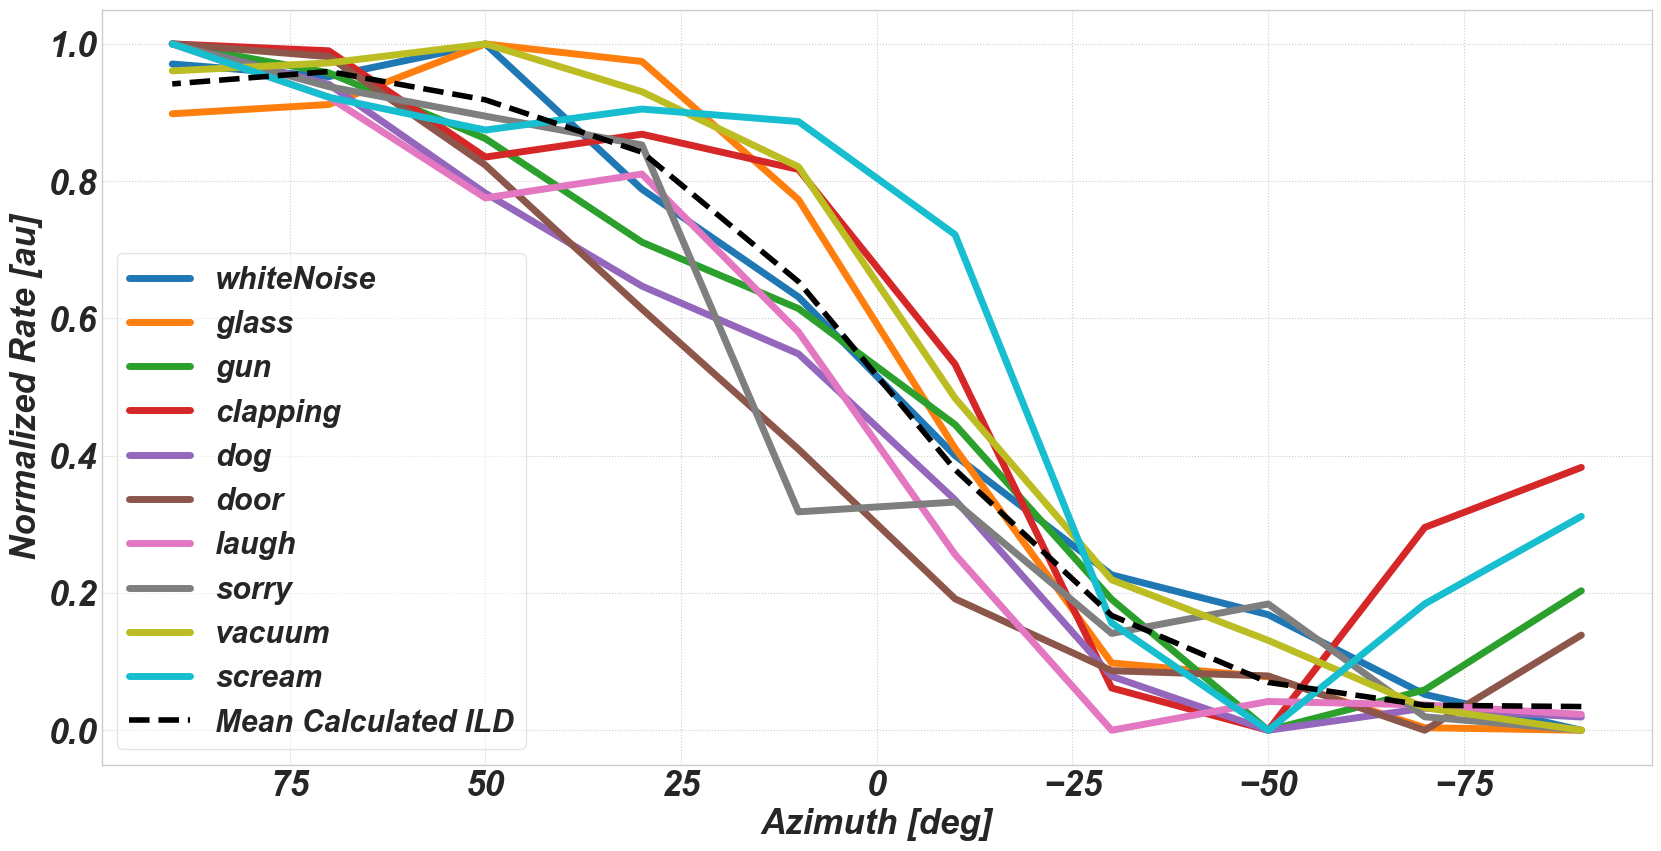

In [122]:
fig = plt.figure()
ax = fig.add_subplot(111)
all_real_ild = np.zeros(r_all.shape[0:2])
errors = np.zeros(len(test_recordings))
for i in range(len(test_recordings)):
    ild = np.mean(g_r_out(r_all[i,:,:,:]),axis=(1,2))
    # normalize
    ild -= np.min(ild)
    ild /= np.max(ild)
    if i== 0:
        # white noise
        p = ax.plot(-test_ilds,ild,label=test_recordings[i])
    else:
        
        p = ax.plot(-test_ilds,ild,label=test_recordings[i])
        
    real_ild = np.squeeze(real_ilds[i])
    real_ild -= np.min(real_ild)
    real_ild /= np.max(real_ild)
    
    all_real_ild[i,:] = real_ild
    
    
    errors[i] = (np.square(real_ild[::-1] - ild)).mean()
    
#     ax.plot(test_ilds,real_ild)

#     ild = np.mean(g_r_out(r_all_contra[i,:,:,:]),axis=(1,2))
#     # normalize
#     ild -= np.min(ild)
#     ild /= np.max(ild)
# #     print(ild)
#     ax.plot(test_ilds,ild,linestyle='--',color = p[0].get_color())
    # we need to add 0 at the beginning and end because it gets cut off ...
   
# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

ax.plot(test_ilds,np.mean(all_real_ild,axis=0),color='black',linestyle='--', linewidth=int(drawing_size/5*0.8),label='Mean Calculated ILD')

print('Mean Error: {0:2.2f}'.format(np.mean(errors)))
print('Mean Error: {0:2.2f}'.format(np.mean(errors)))

# ax.set_xticklabels(np.concatenate([[0],np.linspace(test_ilds[0],test_ilds[-1],len(ax.get_xticks())-2),[0]]))
ax.invert_xaxis()
# plt.title('LSO Response for Different Recordings')
# plt.xlabel('ILD [dB]')
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Normalized Rate [au]')
# ax2.set_ylabel('ILD [dB]')
# lgd = plt.legend(loc=(1.04,0))
lgd = plt.legend()

plt.savefig(figure_name + 'ild_curve.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'ild_curve.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

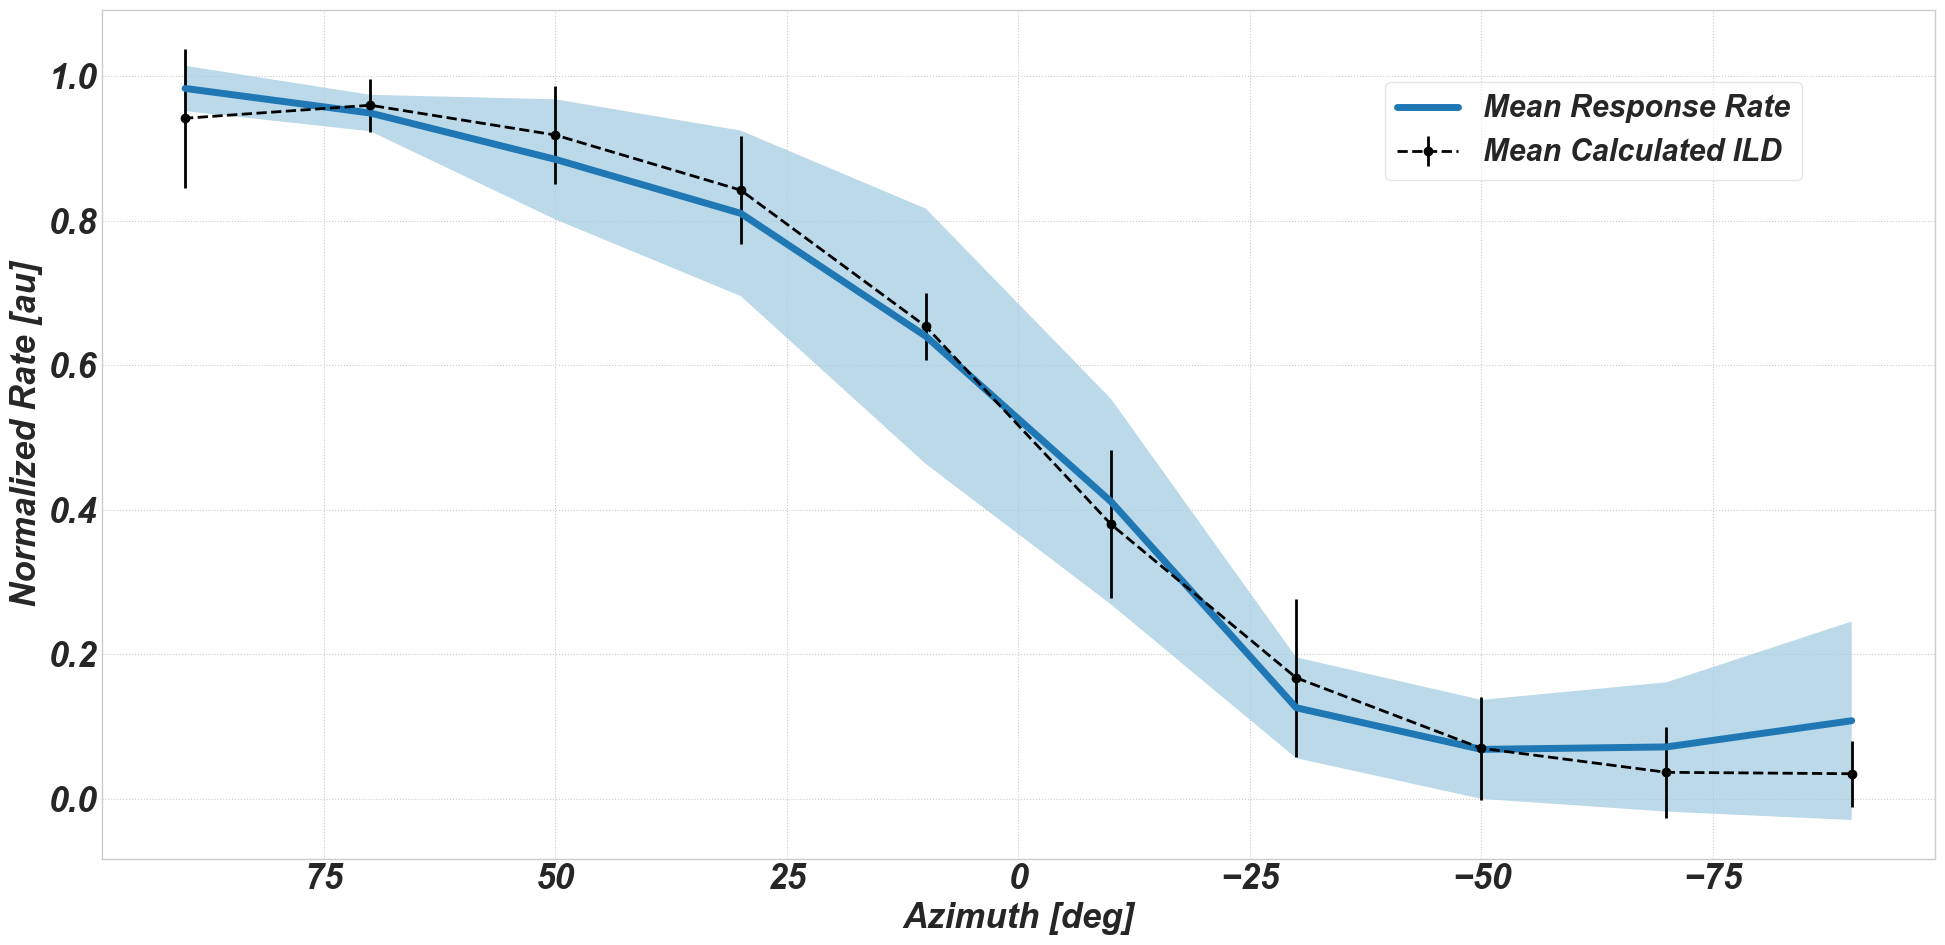

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111)
ilds = np.zeros((len(test_recordings),len(test_ilds)))
ilds_contra = np.zeros((len(test_recordings),len(test_ilds)))
for i in range(len(test_recordings)):
    ild = np.mean(g_r_out(r_all[i,:,:,:]),axis=(1,2))
    # normalize
    ild -= np.min(ild)
    ild /= np.max(ild)

    ilds[i,:] = ild
    
    # contra
    ild = np.mean(g_r_out(r_all_contra[i,:,:,:]),axis=(1,2))
    # normalize
    ild -= np.min(ild)
    ild /= np.max(ild)
    ilds_contra[i,:] = ild


# ax = plot_std_area(-test_ilds,ilds_contra,ax,facecolor='#d9d9d9', alpha=0.7)
# ax.plot(-test_ilds,np.mean(ilds_contra,axis=0),color= '#bdbdbd',label='Contralateral')

ax = plot_std_area(-test_ilds,ilds,ax,facecolor='#9ecae1', alpha=0.7,)
ax.plot(-test_ilds,np.mean(ilds,axis=0),label='Mean Response Rate')

# ax.annotate("A", xy=(-0.10, 1.0), xycoords="axes fraction",fontsize = 35)


# ax.fill_between(dataX,means-stds, means+stds, ,)

contra_response = np.mean(ilds_contra,axis=0)
ipsi_response = np.mean(ilds,axis=0)

# ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
# ax.plot(test_ilds,np.mean(all_real_ild,axis=0),color='black',linestyle='--', linewidth=int(drawing_size/5*0.8),label='Measured ILD')
# plot_std_area(test_ilds,all_real_ild,ax,facecolor='#d9d9d9', alpha=0.7,)
ax.errorbar(test_ilds, np.mean(all_real_ild,axis=0), np.std(all_real_ild,axis=0),color='black',linestyle='--',fmt='-o', linewidth=2,label='Mean Calculated ILD')
# ax2.plot(test_ilds,np.mean(all_real_ild,axis=0),color='black',linestyle='--', linewidth=int(drawing_size/5*0.8),label='Measured ILD')
        

# ax.set_xticklabels(np.concatenate([[0],np.linspace(test_ilds[0],test_ilds[-1],len(ax.get_xticks())-2),[0]]))
# plt.title('Mean LSO Response for Different Recordings')
# ax.set_xticklabels(np.concatenate([[0],np.linspace(test_ilds[0],test_ilds[-1],len(ax.get_xticks())-2),[0]]))
# plt.xlabel('ILD [dB]')



ax.invert_xaxis()
ax.set_xlabel('Azimuth [deg]')
ax.set_ylabel('Normalized Rate [au]')
# ax2.set_ylabel('Normalized ILD [dB]')


lgd = plt.legend(loc=(0.70,0.8))


plt.tight_layout()

plt.savefig(figure_name + 'ild_curve_std.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(figure_name + 'ild_curve_std.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

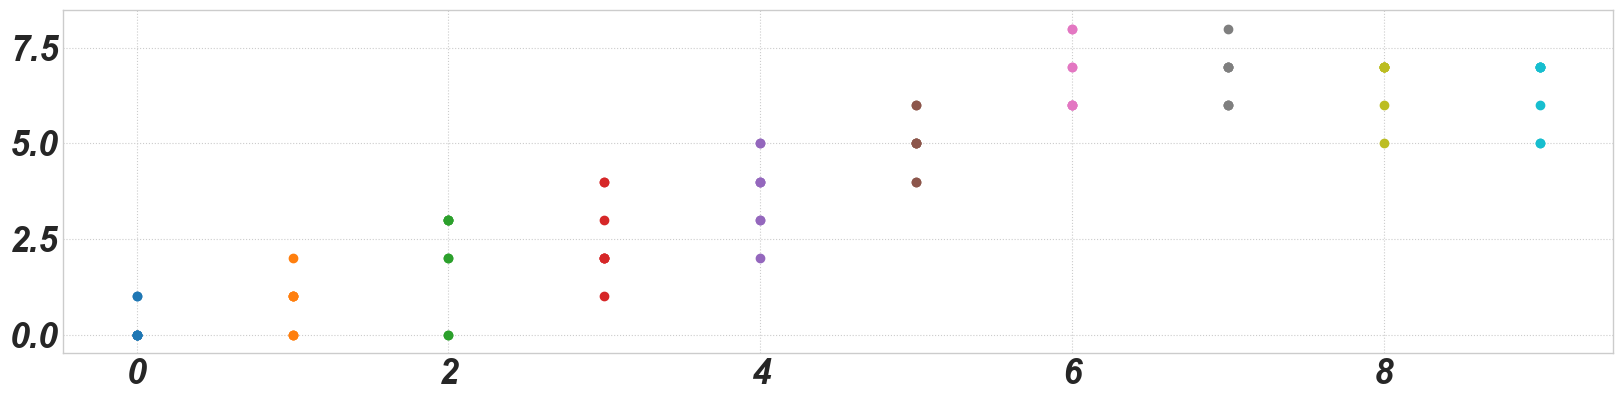

In [46]:
fig = plt.figure()
ax = fig.add_subplot(211)
ilds = np.zeros((len(test_recordings),len(test_ilds)))
ilds_contra = np.zeros((len(test_recordings),len(test_ilds)))
for i in range(len(test_recordings)):
#     for k in range(len(test_ilds)):
    ild = np.mean(g_r_out(r_all[i,:,:,:]),axis=(1,2))
    # normalize
    ild -= np.min(ild)
    ild /= np.max(ild)
    
    for k in range(len(test_ilds)):
#         if k < 6:
        ind_ipsi = np.argmin(np.abs(ipsi_response-ild[k]))
#         ind_contra = np.argmin(contra_response-ild[k])
        ax.scatter(k,ind_ipsi,)
#         else:
#             ind_ipsi = np.argmin(np.abs(contra_response-ild[k]))
#     #         ind_contra = np.argmin(contra_response-ild[k])
#             ax.scatter(k,ind_ipsi,)



plt.show()

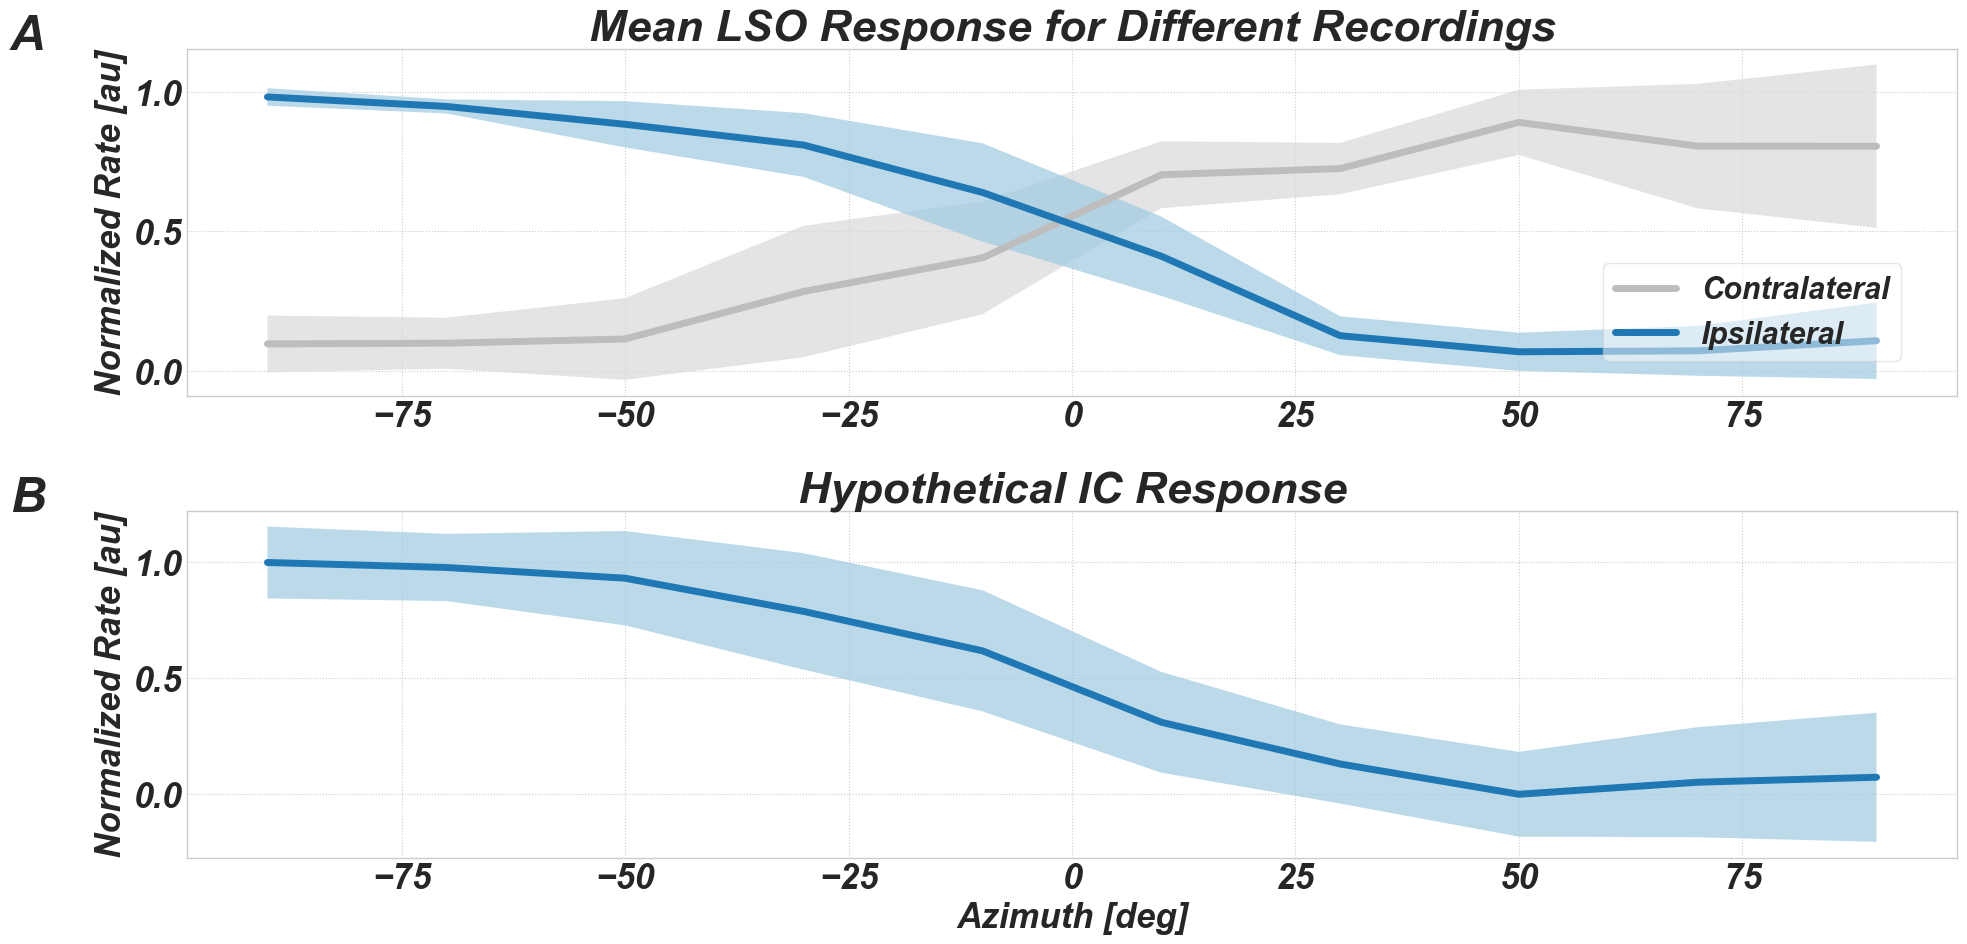

In [88]:
fig = plt.figure()
ax = fig.add_subplot(211)
ilds = np.zeros((len(test_recordings),len(test_ilds)))
ilds_contra = np.zeros((len(test_recordings),len(test_ilds)))
for i in range(len(test_recordings)):
    ild = np.mean(g_r_out(r_all[i,:,:,:]),axis=(1,2))
    # normalize
    ild -= np.min(ild)
    ild /= np.max(ild)

    ilds[i,:] = ild
    
    # contra
    ild = np.mean(g_r_out(r_all_contra[i,:,:,:]),axis=(1,2))
    # normalize
    ild -= np.min(ild)
    ild /= np.max(ild)
    ilds_contra[i,:] = ild


ax = plot_std_area(test_ilds,ilds_contra,ax,facecolor='#d9d9d9', alpha=0.7)
ax.plot(test_ilds,np.mean(ilds_contra,axis=0),color= '#bdbdbd',label='Contralateral')

ax = plot_std_area(test_ilds,ilds,ax,facecolor='#9ecae1', alpha=0.7,)
ax.plot(test_ilds,np.mean(ilds,axis=0),label='Ipsilateral')
lgd = plt.legend(loc=(0.80,0.1))

ax.annotate("A", xy=(-0.10, 1.0), xycoords="axes fraction",fontsize = 35)


# ax.fill_between(dataX,means-stds, means+stds, ,)

        

# ax.set_xticklabels(np.concatenate([[0],np.linspace(test_ilds[0],test_ilds[-1],len(ax.get_xticks())-2),[0]]))
plt.title('Mean LSO Response for Different Recordings')
# plt.xlabel('Azimuth [deg]')
plt.ylabel('Normalized Rate [au]')

ax = fig.add_subplot(212,sharex=ax)
means_ipsi = np.mean(ilds,axis=0)
stds_ipsi = np.std(ilds,axis=0,ddof=1)

means_contra = np.mean(ilds_contra,axis=0)
stds_contra = np.std(ilds_contra,axis=0,ddof=1)

means = means_ipsi-means_contra
stds = np.sqrt((stds_ipsi+stds_contra)/2)


means -= np.min(means)

# calcualte the std sqrt((std1+std2)/2) and then divide it by the normalization value of means 
stds = np.sqrt((stds_ipsi+stds_contra)/2) /np.max(means)
means /= np.max(means)

ax.fill_between(test_ilds,means-stds, means+stds,facecolor='#9ecae1', alpha=0.7)
ax.plot(test_ilds,means)

        

# ax.set_xticklabels(np.concatenate([[0],np.linspace(test_ilds[0],test_ilds[-1],len(ax.get_xticks())-2),[0]]))
plt.title('Hypothetical IC Response')
plt.xlabel('Azimuth [deg]')
plt.ylabel('Normalized Rate [au]')
# plt.text(-110.0, 5, 'Normalized Rate [au]', va='center', ha='center', rotation='vertical')

plt.tight_layout()

ax.annotate("B", xy=(-0.10, 1.0), xycoords="axes fraction",fontsize = 35)

# plt.savefig(figure_name + 'ild_curve_std.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.savefig(figure_name + 'ild_curve_std.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()